# Applied ML

In [345]:
# Normal stack of pandas, numpy, matplotlib and seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Statistical test library
import scipy.stats as stats

%matplotlib inline

# Data pre-processing

In [346]:
# Load the dataset
#original = pd.read_csv("CrowdstormingDataJuly1st.csv", delimiter=',', na_values=['NA'])
original = pd.read_csv("CrowdstormingDataJuly1st.csv")

In [347]:
original.describe()

/home/raccct/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,rater1,rater2,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
count,145765.000000,143785.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,124621.000000,124621.000000,146028.000000,146028.000000,145865.000000,1.458650e+05,1.458650e+05,145865.000000,1.458650e+05,145865.000000
mean,181.935938,76.075662,2.921166,1.278344,0.708241,0.934581,0.338058,0.385364,0.011381,0.012559,0.264255,0.302862,1534.827444,29.642842,0.346276,1.969741e+04,6.310849e-04,0.452026,2.044023e+04,0.002994
std,6.738726,7.140906,3.413633,1.790725,1.116793,1.383059,0.906481,0.795333,0.107931,0.112889,0.295382,0.293020,918.736625,27.496189,0.032246,1.271262e+05,4.735857e-03,0.217469,1.306157e+05,0.019723
min,161.000000,54.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-0.047254,2.000000e+00,2.235373e-07,-1.375000,2.000000e+00,0.000001
25%,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,641.000000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1604.000000,21.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,3.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,2345.000000,44.000000,NaN,NaN,NaN,NaN,NaN,NaN
max,203.000000,100.000000,47.000000,29.000000,14.000000,18.000000,23.000000,14.000000,3.000000,2.000000,1.000000,1.000000,3147.000000,161.000000,0.573793,1.975803e+06,2.862871e-01,1.800000,2.029548e+06,1.060660


In [348]:
# First glimpse at data content
original.ix[:10,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,1,0,0
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,0,0,0


In [349]:
# Further columns of dataset
original.ix[:10,13:]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,0,0,0,47704.jpg,0.00,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,0,0,0,22356.jpg,1.00,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,0,0,0,16528.jpg,0.25,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
9,0,0,0,36499.jpg,0.00,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


Challenges in dataset:

- Skin ratings don't match -> take average
- Picture was missing -> exclude from training
- No cards drawn in some dyads


Prune dataset where there is no rater information

In [350]:
def round_quarter(x):
    return round(x*4)/4

In [351]:
rater = original.copy()
rater['rater_mean'] = round_quarter(rater[['rater1','rater2']].mean(axis=1))
rater['rater_mean'].head()

0    0.50
1    0.75
2     NaN
3     NaN
4     NaN
Name: rater_mean, dtype: float64

In [352]:
rater = rater.dropna(subset=['rater_mean'])
rater['rater_mean'].head()

0    0.50
1    0.75
5    0.00
6    0.00
7    1.00
Name: rater_mean, dtype: float64

Get rid of unusable columns

In [353]:
features = rater.drop(['rater1','rater2', 'rater_mean'], 1)
features.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,photoID,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,95212.jpg,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,1663.jpg,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,3868.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,47704.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,22356.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


In [367]:
features.ix[:3,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,games,victories,ties,defeats,goals,yellowCards
0,901,1046,70,3,1382,16,17,0,0,0,1,0,0
1,739,919,51,1,320,18,27,0,0,0,1,0,1


In [368]:
features.ix[:3,13:]

,yellowReds,redCards,photoID,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,1532,0,0,62,92,34,74,99,34
1,0,0,497,1,1,26,24,115,27,31,116


Convert string values to floats by LabelEncoder to make them readable by the classifier

In [355]:
features = features.drop('position', axis=1)
features = features.drop('Alpha_3', axis=1)
#features = features.ix[:,0:7]
features.head()


,playerShort,player,club,leagueCountry,birthday,height,weight,games,victories,ties,...,redCards,photoID,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,1,0,0,...,0,95212.jpg,1,1,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,1,0,0,...,0,1663.jpg,2,2,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,1,0,0,...,0,3868.jpg,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,1,1,0,...,0,47704.jpg,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,1,0,0,...,0,22356.jpg,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752


In [356]:
type(features)

pandas.core.frame.DataFrame

In [357]:
from sklearn.preprocessing import LabelEncoder
features = features.apply(LabelEncoder().fit_transform)
features.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,games,victories,ties,...,redCards,photoID,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,901,1046,70,3,1382,16,17,0,0,0,...,0,1532,0,0,62,92,34,74,99,34
1,739,919,51,1,320,18,27,0,0,0,...,0,497,1,1,26,24,115,27,31,116
5,0,392,34,0,360,21,16,0,0,0,...,0,1081,2,3,61,42,89,92,47,84
6,45,425,48,0,446,26,25,0,1,0,...,0,1175,2,3,61,42,89,92,47,84
7,64,440,54,0,158,19,13,0,0,0,...,0,803,2,3,61,42,89,92,47,84


In [358]:
from collections import defaultdict
d = defaultdict(LabelEncoder)

# Encoding the variable
#fit = features.apply(lambda x: d[x.name].fit_transform(x))

# Inverse the encoded
#fit.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
#df.apply(lambda x: d[x.name].transform(x))

Prepared dataset for further processing with ML methods

In [360]:
X_train = features
#Y_train = list(rater['rater_mean'].values)
Y_train = np.asarray(rater['rater_mean'], dtype="|S6")
X_train = X_train.tail(-3)
#X_train = X_train.drop(1, axis=0)
Y_train = Y_train[3:]
print(type(Y_train))
print(X_train.shape)
print(Y_train.shape)
print('FEATURES')
print(X_train.head(10))
print('LABELS')
print(Y_train)

<class 'numpy.ndarray'>
(124618, 24)
(124618,)
FEATURES
    playerShort  player  club  leagueCountry  birthday  height  weight  games  \
6            45     425    48              0       446      26      25      0   
7            64     440    54              0       158      19      13      0   
8            89     454    49              0       569      32      25      0   
9           103     456     2              2       563      19      15      0   
10          131     484    69              3      1157      16      19      1   
11          151     497    34              0       209      20      19      0   
12          187     519    31              2      1306      26      25      0   
13          277     577    34              0      1121      25      22      0   
14          278     578    92              0       654      24      19      0   
15          348     635    11              2      1056      25      21      0   

    victories  ties  ...    redCards  photoID  refNu

## Machine Learning by RandomForestClassifier

In [361]:
from sklearn.ensemble import RandomForestClassifier

In [362]:
rfc = RandomForestClassifier()
print(rfc)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [363]:
# import test data set to test classifier
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [364]:
# Plug of unplug live data
X = X_train
y = Y_train

In [365]:
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [323]:
# test prediction
X_pred = [[3, 5, 4, 2], [5, 4, 3, 2]]
rfc.predict(X_pred)

NotFittedError: Estimator not fitted, call `fit` before exploiting the model.

In [370]:
# test prediction
X_pred = [901,1046,70,3,1382,16,17,0,0,0,1,0,0,0,0,1532,0,0,62,92,34,74,99,34]
X_pred = features.head(3)
rfc.predict(X_pred)

array([b'0.5', b'0.75', b'0.0'], 
      dtype='|S6')

## Inspect most relevant features of RandomForest

Feature ranking:
1. feature 15 (0.138950)
2. feature 1 (0.136100)
3. feature 4 (0.136088)
4. feature 0 (0.135301)
5. feature 2 (0.121899)
6. feature 6 (0.112754)
7. feature 5 (0.107609)
8. feature 3 (0.037564)
9. feature 17 (0.007268)
10. feature 21 (0.007044)
11. feature 23 (0.006893)
12. feature 18 (0.006454)
13. feature 19 (0.006010)
14. feature 7 (0.005992)
15. feature 16 (0.005791)
16. feature 22 (0.005711)
17. feature 20 (0.005045)
18. feature 8 (0.004612)
19. feature 11 (0.004240)
20. feature 10 (0.003030)
21. feature 12 (0.002729)
22. feature 9 (0.002496)
23. feature 14 (0.000218)
24. feature 13 (0.000201)


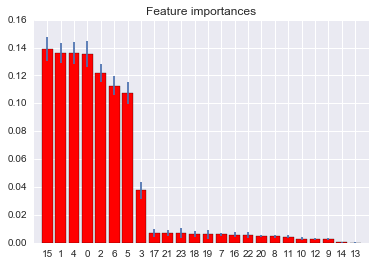

In [372]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()